# Multi Unconfoundedness

Multi Unconfoundedness is observational/quasi experimental scenario of causal inference with multiple treatments. Treatments are not randomly assigned so we need to control confounders to estimate causal effect

# Data

In our research we should estimate effect of different gamification mechanics.
Our outcome is number of sessions per month.

Treatments:
- d_0: No mechanics used
- d_1: Used first set of mechanics
- d_2: Used second set of mechanics

DGP is from Causalis. Read more at https://causalis.causalcraft.com/articles/generate_multitreatment_gamma_26

In [1]:
from causalis.scenarios.multi_unconfoundedness.dgp import generate_multitreatment_gamma_26

df = generate_multitreatment_gamma_26(return_causal_data=False, include_oracle=True)

In [2]:
df.head()

,y,d_0,d_1,d_2,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident,support_tickets_q,...,m_obs_d_1,tau_link_d_1,m_d_2,m_obs_d_2,tau_link_d_2,g_d_0,g_d_1,g_d_2,cate_d_1,cate_d_2
0,0.422769,1.0,0.0,0.0,27.656605,3.198667,89.609464,0.0,1.0,0.0,...,0.246687,-0.352005,0.220781,0.220781,0.494166,3.279384,2.306314,5.375338,-0.973070,2.095954
1,7.566231,1.0,0.0,0.0,23.798386,3.362415,102.337236,0.0,0.0,3.0,...,0.179393,-0.307360,0.236958,0.236958,0.420278,2.807850,2.064853,4.274630,-0.742997,1.466780
2,1.702662,0.0,0.0,1.0,28.425009,3.391819,102.660712,0.0,1.0,1.0,...,0.210566,-0.320189,0.218245,0.218245,0.502415,3.069919,2.228798,5.073677,-0.841121,2.003758
3,1.827530,1.0,0.0,0.0,18.860066,4.071175,83.593417,0.0,0.0,2.0,...,0.176729,-0.316241,0.237639,0.237639,0.441677,2.716805,1.980234,4.225485,-0.736571,1.508680
4,1.429843,0.0,1.0,0.0,17.853087,3.140075,79.209870,0.0,1.0,1.0,...,0.232492,-0.350130,0.247027,0.247027,0.493624,3.224354,2.271869,5.282273,-0.952485,2.057919


In [3]:
print(f"Ground truth ATE for d_1 vs d_0 is {df['cate_d_1'].mean()}")
print(f"Ground truth ATE for d_2 vs d_0 is {df['cate_d_2'].mean()}")

Ground truth ATE for d_1 vs d_0 is -1.1950325692907122
Ground truth ATE for d_2 vs d_0 is 2.530398527003894


In [4]:
# wrap it in MultiCausalData
from causalis.data_contracts.multicausaldata import MultiCausalData
multi_causaldata = MultiCausalData(df = df,
                        treatment_names=['d_0', 'd_1', 'd_2'],
                        control_treatment= 'd_0',
                        outcome='y',
                        confounders=['tenure_months',
                                     'avg_sessions_week',
                                     'spend_last_month',
                                     'premium_user',
                                     'urban_resident',
                                     'support_tickets_q',
                                     'discount_eligible',
                                     'credit_utilization'])
multi_causaldata

MultiCausalData(df=(100000, 12), treatment_names=['d_0', 'd_1', 'd_2'], control_treatment='d_0')outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'premium_user', 'urban_resident', 'support_tickets_q', 'discount_eligible', 'credit_utilization'], user_id=None, 

# EDA

In [5]:
from causalis.shared import outcome_stats
outcome_stats(multi_causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,d_0,50115,3.758417,3.106725,0.015427,0.887906,1.626326,2.937863,4.957415,7.577785,50.239323
1,d_2,25008,6.541717,5.539708,0.043125,1.512610,2.775637,5.102611,8.584913,13.348761,79.125235
2,d_1,24877,2.980817,2.412763,0.009022,0.711997,1.306774,2.352234,3.946463,5.985070,25.169272


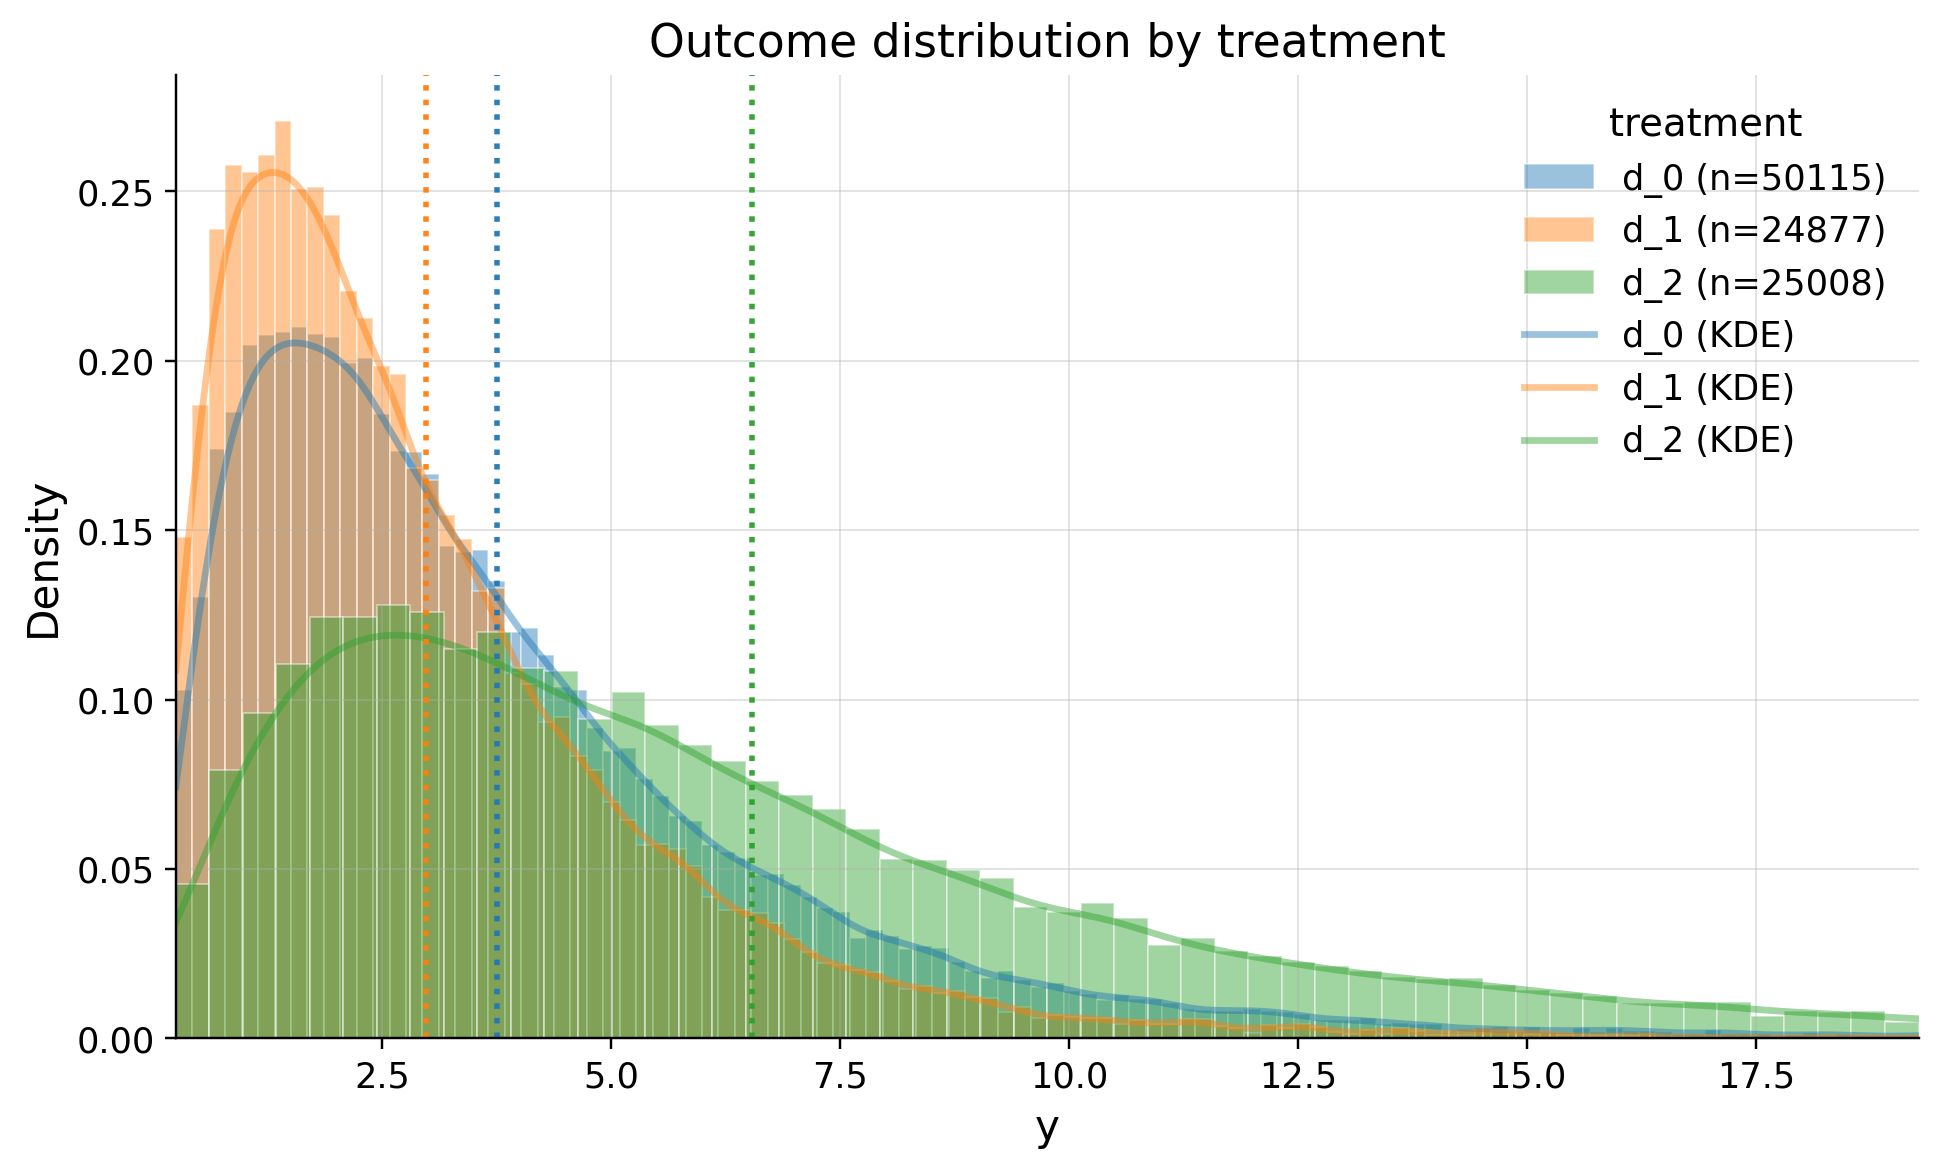

In [6]:
from causalis.shared.outcome_plots import outcome_plot_dist
outcome_plot_dist(multi_causaldata)

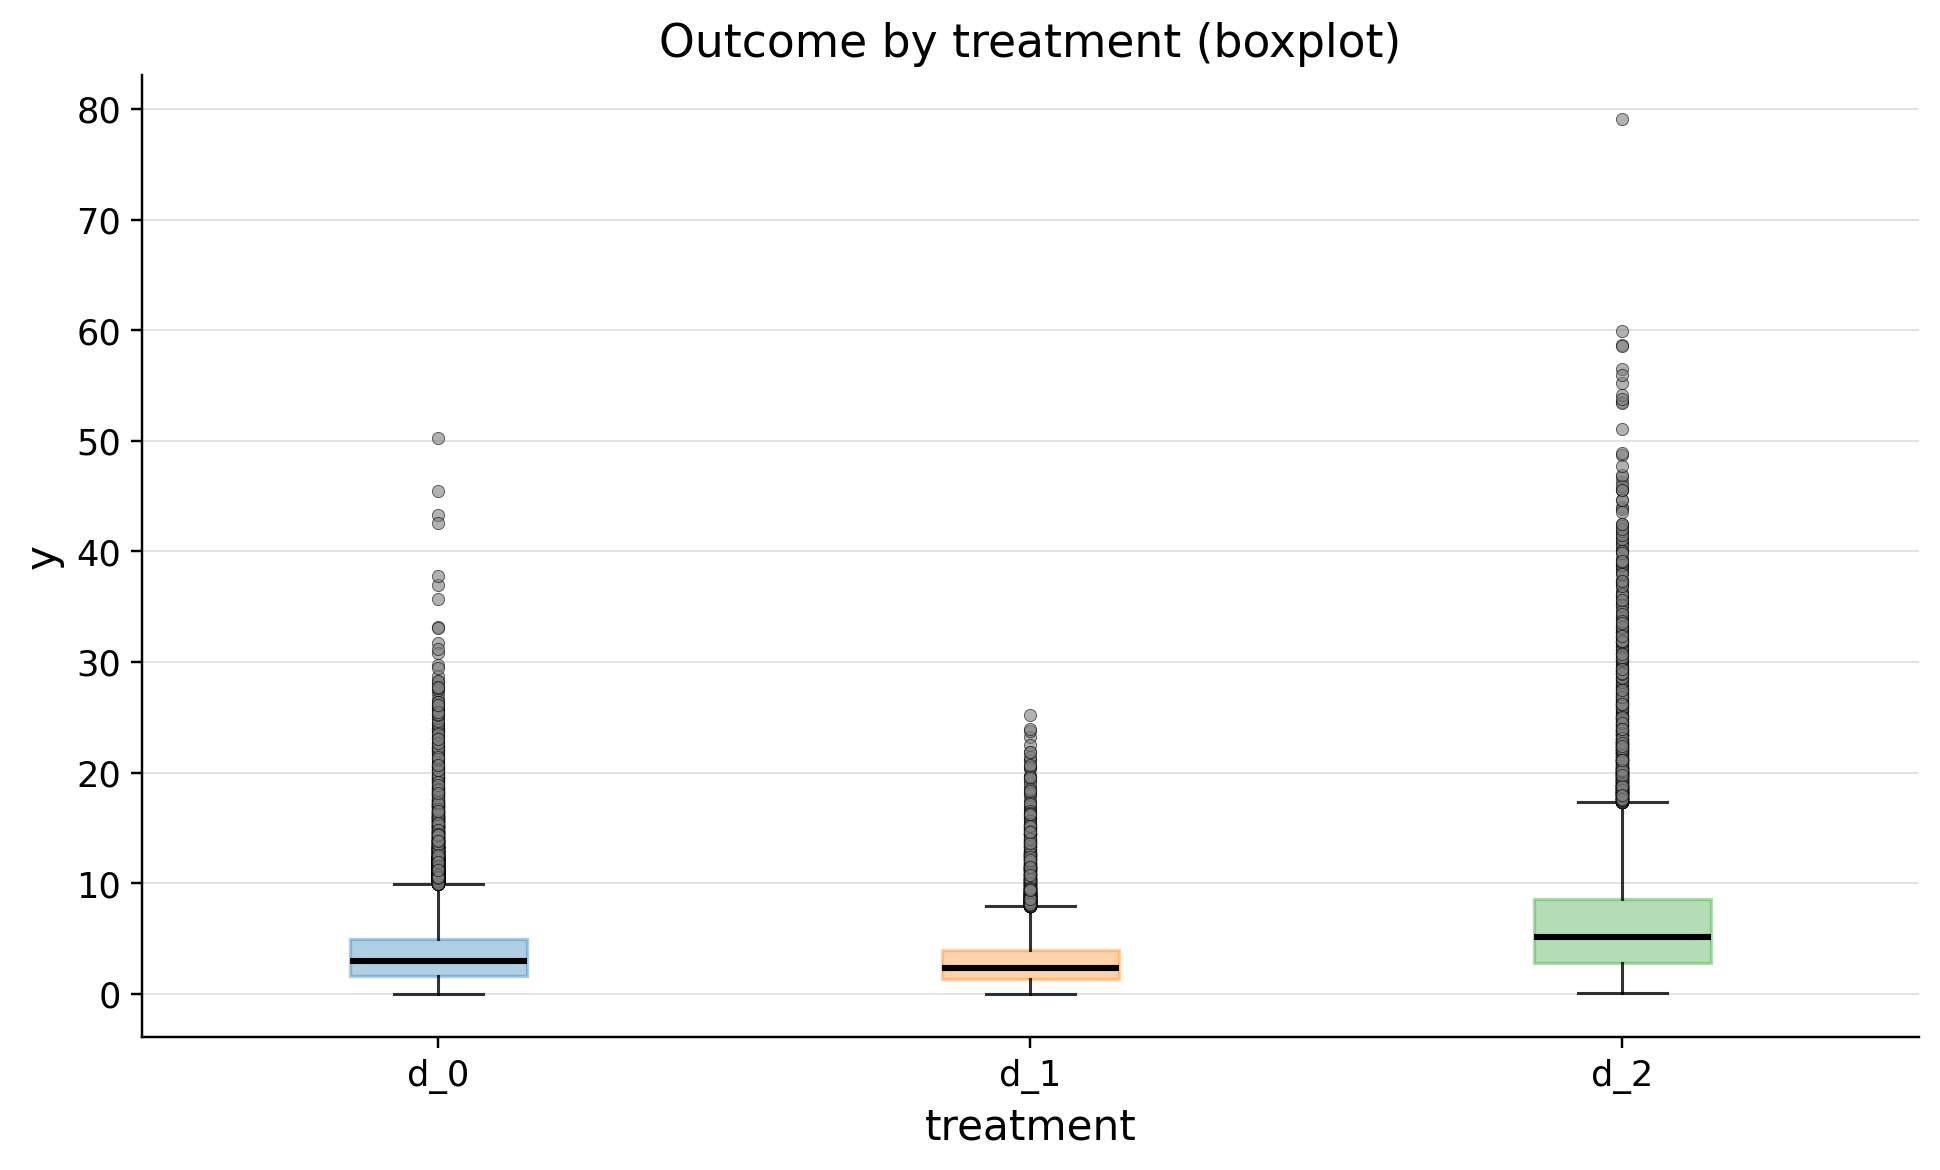

In [7]:
from causalis.shared.outcome_plots import outcome_plot_boxplot
outcome_plot_boxplot(multi_causaldata)

In [8]:
from causalis.shared import outcome_outliers

outcome_outliers(multi_causaldata)

,treatment,n,outlier_count,outlier_rate,lower_bound,upper_bound,has_outliers,method,tail
0,d_0,50115,2288,0.045655,-3.370308,9.954048,True,iqr,both
1,d_2,25008,1173,0.046905,-5.938277,17.298826,True,iqr,both
2,d_1,24877,1067,0.042891,-2.652760,7.905997,True,iqr,both


As we see there are heavy tails in distribution of outcome. We won't trim them because high activity means high income of revenue for us

In [9]:
from causalis.shared import confounders_balance

confounders_balance(multi_causaldata, 'd_0', 'd_1')

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,avg_sessions_week,4.827957,5.330050,0.502092,0.253187,0.00000
1,premium_user,0.217440,0.296861,0.079421,0.182466,0.00000
2,tenure_months,23.672462,25.752063,2.079601,0.176703,0.00000
3,spend_last_month,82.894719,96.062898,13.168180,0.149709,0.00000
4,discount_eligible,0.325870,0.395626,0.069756,0.145642,0.00000
5,urban_resident,0.585912,0.638421,0.052509,0.107919,0.00000
6,support_tickets_q,1.478140,1.492302,0.014162,0.011558,0.47358
7,credit_utilization,0.449627,0.448996,0.000632,-0.005811,0.86692


In [10]:
confounders_balance(multi_causaldata, 'd_0', 'd_2')

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,premium_user,0.217440,0.274072,0.056632,0.131823,0.00000
1,avg_sessions_week,4.827957,5.059494,0.231536,0.116747,0.00000
2,spend_last_month,82.894719,89.334021,6.439302,0.076205,0.00000
3,support_tickets_q,1.478140,1.569378,0.091238,0.073883,0.00000
4,discount_eligible,0.325870,0.356006,0.030136,0.063605,0.00000
5,urban_resident,0.585912,0.604687,0.018774,0.038256,0.00002
6,tenure_months,23.672462,23.391337,0.281125,-0.024131,0.00373
7,credit_utilization,0.449627,0.451855,0.002228,0.020493,0.02836


And data is highly biased by confounders

# Inference

In [11]:
from causalis.scenarios.multi_unconfoundedness import MultiTreatmentIRM

model = MultiTreatmentIRM().fit(multi_causaldata)

## Explanation of `MultiTreatmentIRM`


### 0) Assumptions


- **SUTVA / consistency**: no interference, no hidden treatment versions, and observed outcome equals the potential outcome under realized arm.
- **Multi-arm unconfoundedness**:
$$
\left(Y(0),Y(1),\dots,Y(K-1)\right) \perp D \mid X
$$
where $D$ is one-hot with baseline arm $D_0$.
- **Positivity / overlap**:
$$
\Pr(D_k=1\mid X=x)>0,\quad \forall k=0,\dots,K-1.
$$
In practice, the implementation enforces stability with propensity trimming.


### 1) Data and estimand


For each unit $i$ we observe $(Y_i, X_i, D_i)$ with one-hot $D_i=(D_{i0},\dots,D_{i,K-1})$ and $\sum_k D_{ik}=1$.

`MultiTreatmentIRM` estimates vector contrasts against baseline:
$$
\theta_k = \mathbb{E}[Y(k)-Y(0)],\quad k=1,\dots,K-1.
$$
So outputs are pairwise ATEs such as `d_1 vs d_0`, `d_2 vs d_0`.


### 2) Nuisance functions


For each arm $k$:
$$
g_k(x)=\mathbb{E}[Y\mid X=x, D_k=1],\qquad
m_k(x)=\Pr(D_k=1\mid X=x),\ \sum_{k=0}^{K-1}m_k(x)=1.
$$
These are estimated out-of-fold by cross-fitting (to reduce overfitting bias in final moments).


### 3) Cross-fitting logic


With folds $I_1,\dots,I_F$:
1. Train multiclass propensity model on $I_f^c$, predict $\hat m_k$ on $I_f$.
2. For each arm $k$, train outcome model on rows in $I_f^c$ where $D_k=1$, predict $\hat g_k$ on $I_f$.
3. Repeat for all folds and stitch predictions.


### 4) Multiclass trimming


Predicted propensities are stabilized by lower-bound trimming and row renormalization:
$$
\tilde m_{ik}=\max(\hat m_{ik},\varepsilon),\qquad
\hat m^{trim}_{ik}=\frac{\tilde m_{ik}}{\sum_{j=0}^{K-1}\tilde m_{ij}}.
$$
This keeps each row on the probability simplex and avoids exploding IPW weights.


### 5) Orthogonal score for each contrast


Define residuals and IPW representers:
$$
u_{ik}=Y_i-\hat g_k(X_i),\qquad
h_{ik}=\frac{D_{ik}}{\hat m^{trim}_{ik}}.
$$
(If `normalize_ipw=True`, $h_{ik}$ is column-normalized in Hajek style.)

For each active arm $k>0$ vs baseline $0$:
$$
\psi_{b,ik}=\big(\hat g_k(X_i)-\hat g_0(X_i)\big)+u_{ik}h_{ik}-u_{i0}h_{i0},
\qquad \psi_a=-1.
$$
Moment condition:
$$
\mathbb{E}_n[\psi_a\theta_k+\psi_{b,\cdot k}]=0
\ \Rightarrow\
\hat\theta_k=\mathbb{E}_n[\psi_{b,\cdot k}].
$$


### 6) Inference


Influence function per contrast:
$$
\widehat{IF}_{ik}=\psi_{b,ik}-\hat\theta_k.
$$
Then
$$
\widehat{SE}(\hat\theta_k)=\sqrt{\frac{\mathrm{Var}_n(\widehat{IF}_{\cdot k})}{n}},
$$
with Wald CI
$$
\hat\theta_k \pm z_{1-\alpha/2}\widehat{SE}(\hat\theta_k).
$$
P-values are normal-approximation; significance flag is Bonferroni-adjusted across $K-1$ contrasts.


### 7) Relative effect reported by the model


Baseline mean is estimated via orthogonal signal:
$$
\psi_{\mu_c,i}=\hat g_0(X_i)+u_{i0}h_{i0},\qquad \hat\mu_c=\mathbb{E}_n[\psi_{\mu_c}].
$$
Relative effect (%):
$$
\hat\tau_k^{rel}=100\cdot\frac{\hat\theta_k}{\hat\mu_c},
$$
with CI from delta-method variance (as implemented in `model.py`).


In [12]:
dml_result = model.estimate(score='ATE')
dml_result.summary()

,d_1 vs d_0,d_2 vs d_0
field,,
estimand,ATE,ATE
model,MultiTreatmentIRM,MultiTreatmentIRM
value,"-1.1832 (ci_abs: -1.2233, -1.1431)","2.5298 (ci_abs: 2.4565, 2.6031)"
value_relative,"-29.9638 (ci_rel: -30.8175, -29.1101)","64.0643 (ci_rel: 61.9680, 66.1606)"
alpha,0.0500,0.0500
p_value,0.0000,0.0000
is_significant,True,True
n_treated,24877,25008
n_control,50115,50115


# Refutation

## Unconfoundedness

In [13]:
from causalis.scenarios.multi_unconfoundedness.refutation.unconfoundedness import run_unconfoundedness_diagnostics
rep_uc = run_unconfoundedness_diagnostics(multi_causaldata, dml_result)
rep_uc["summary"]  # comparison, metric, value, flag

,comparison,metric,value,flag
0,d_0 vs d_1,balance_max_smd,0.013307,GREEN
1,d_0 vs d_1,balance_frac_violations,0.0,GREEN
2,d_0 vs d_1,balance_pass,True,GREEN
3,d_0 vs d_2,balance_max_smd,0.004068,GREEN
4,d_0 vs d_2,balance_frac_violations,0.0,GREEN
5,d_0 vs d_2,balance_pass,True,GREEN
6,overall,balance_max_smd,0.013307,GREEN
7,overall,balance_frac_violations,0.0,GREEN
8,overall,balance_pass,True,GREEN


## Sensitivity

In [14]:
from causalis.scenarios.multi_unconfoundedness.refutation.unconfoundedness.sensitivity import (
    sensitivity_analysis, get_sensitivity_summary
)

In [15]:
from causalis.scenarios.multi_unconfoundedness.refutation.unconfoundedness import sensitivity_benchmark


bench = sensitivity_benchmark(dml_result, benchmarking_set=["tenure_months"])
bench

,cf_y,r2_y,r2_d,rho,theta_long,theta_short,delta
d_1 vs d_0,3.022036e-07,3.022035e-07,1.351745e-07,-1.0,-1.183219,-1.146914,-0.036304
d_2 vs d_0,3.022036e-07,3.022035e-07,1.461506e-07,-1.0,2.529790,2.470708,0.059082


In [16]:
res = sensitivity_analysis(
    dml_result,                      # MultiCausalEstimate
    multi_causaldata,                     # MultiCausalData (optional but recommended for validation)
    cf_y=0.05,                # confounding strength in outcome residual
    r2_d=0.05,                # confounding strength in treatment residual
    rho=1.0,
    H0=0.0,
    alpha=0.05,
)

res

{'theta': array([-1.18321853,  2.52979027]),
 'se': array([0.02044409, 0.03741762]),
 'alpha': 0.05,
 'z': 1.959963984540054,
 'H0': 0.0,
 'sampling_ci': array([[-1.22328822, -1.14314885],
        [ 2.45645308,  2.60312746]]),
 'theta_bounds_cofounding': array([[-1.61866521, -0.74777186],
        [ 2.1016666 ,  2.95791394]]),
 'bias_aware_ci': array([[-1.65985899, -0.70803275],
        [ 2.02990876,  3.03312867]]),
 'max_bias_base': array([8.48841832, 8.34566666]),
 'max_bias': array([0.43544667, 0.42812367]),
 'bound_width': array([0.43544667, 0.42812367]),
 'sigma2': 11.79593879649448,
 'nu2': array([6.10830955, 5.90458744]),
 'rv': array([0.27985187, 0.64760316]),
 'rva': array([0.26617826, 0.63406235]),
 'contrast_labels': ['d_1 vs d_0', 'd_2 vs d_0'],
 'params': {'cf_y': 0.05,
  'r2_d': array([0.05, 0.05]),
  'rho': array([1., 1.]),
  'use_signed_rr': False}}

## Overlap

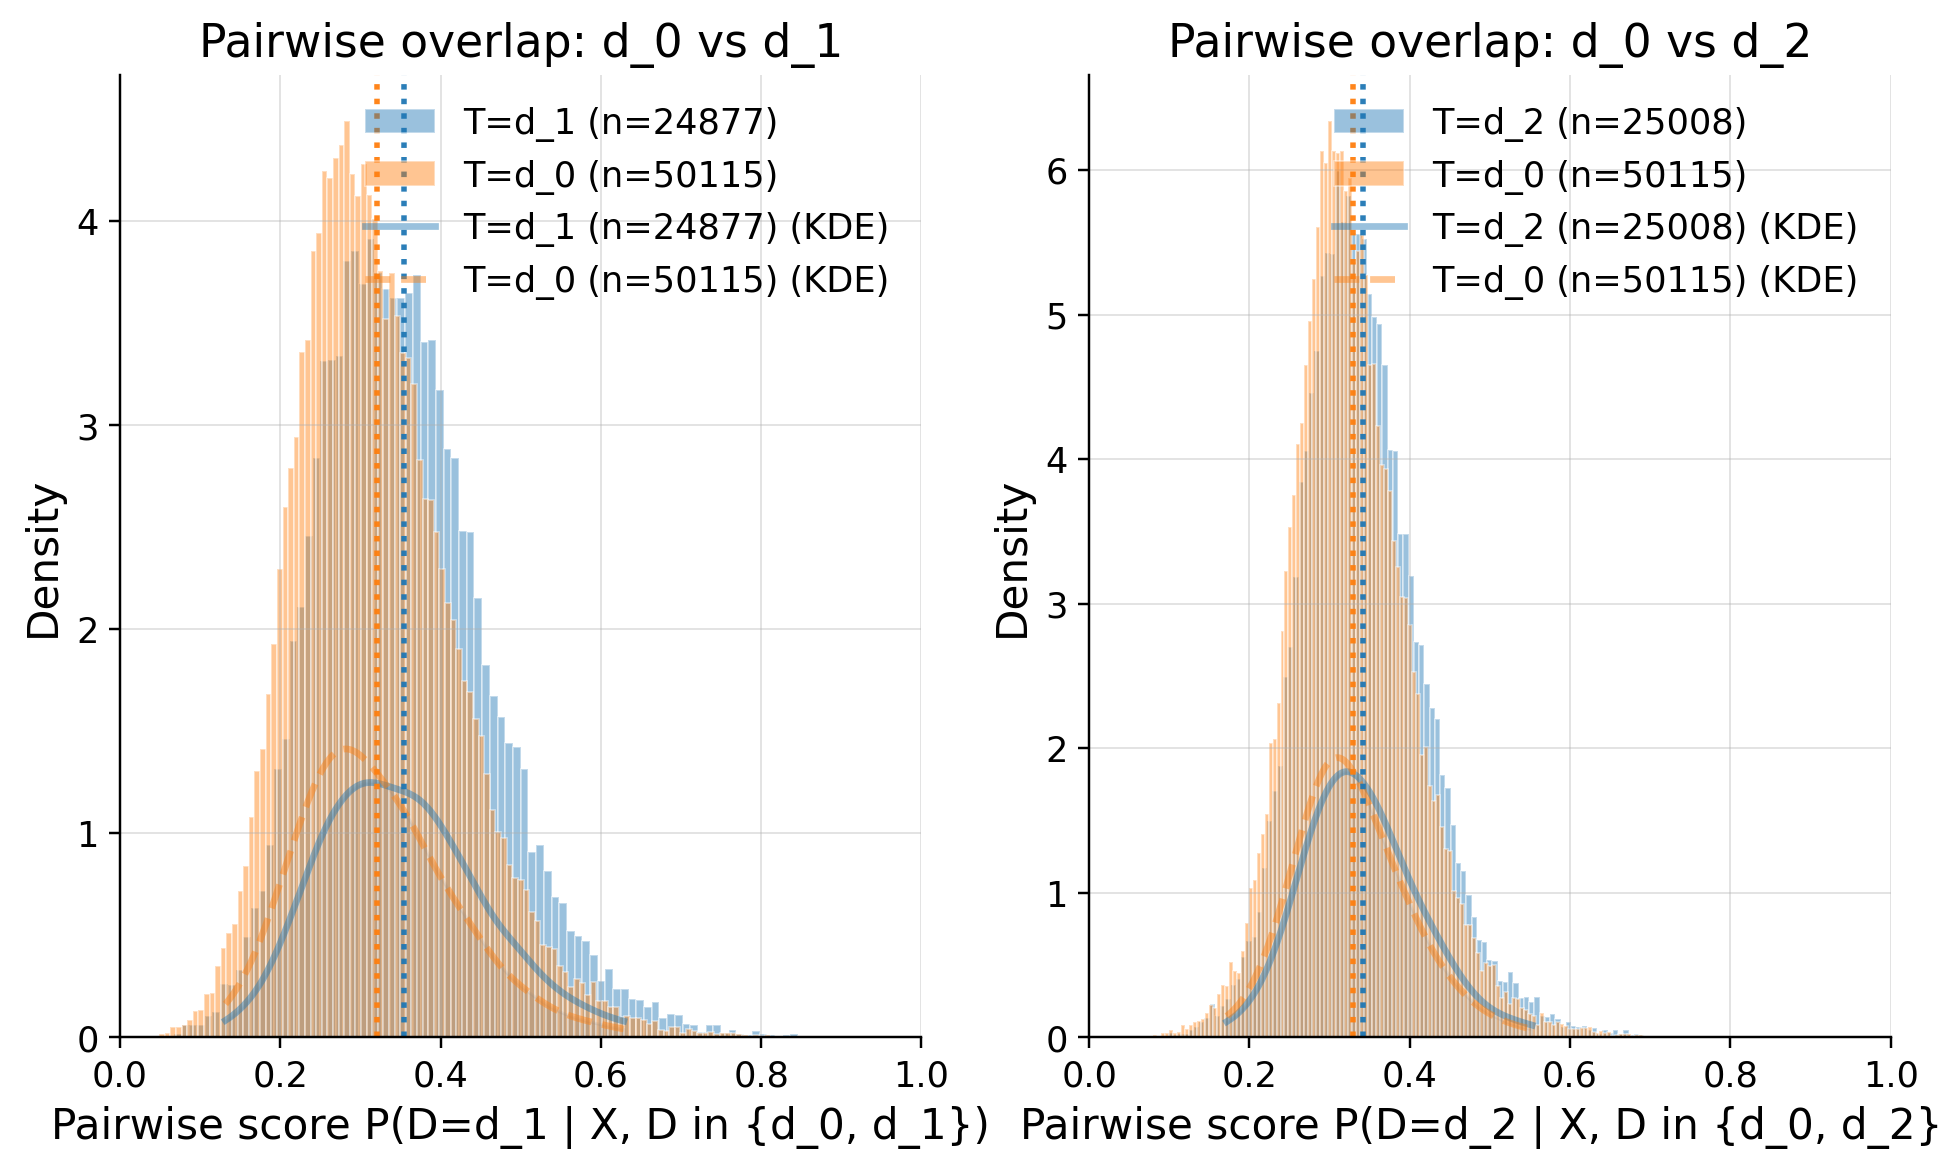

In [17]:
from causalis.scenarios.multi_unconfoundedness.refutation.overlap import overlap_plot

overlap_plot(multi_causaldata,dml_result)

In [18]:
from causalis.scenarios.multi_unconfoundedness.refutation.overlap import run_overlap_diagnostics
rep_overlap = run_overlap_diagnostics(multi_causaldata, dml_result)
rep_overlap["summary"]

,comparison,metric,value,flag
0,d_0 vs d_1,edge_0.01_below,0.0,GREEN
1,d_0 vs d_1,edge_0.01_above,0.0,GREEN
2,d_0 vs d_1,KS,0.141067,GREEN
3,d_0 vs d_1,AUC,0.596814,GREEN
4,d_0 vs d_1,ESS_treated_ratio,0.895799,GREEN
5,d_0 vs d_1,ESS_baseline_ratio,0.954377,GREEN
6,d_0 vs d_1,clip_m_total,0.0,GREEN
7,d_0 vs d_1,overlap_pass,True,GREEN
8,d_0 vs d_2,edge_0.01_below,0.0,GREEN
9,d_0 vs d_2,edge_0.01_above,0.0,GREEN


## SUTVA

In [19]:
from causalis.shared import print_sutva_questions
print_sutva_questions()

1.) Are your clients independent (i). Outcome of ones do not depend on others?
2.) Are all clients have full window to measure metrics?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


## Score

In [20]:
from causalis.scenarios.multi_unconfoundedness.refutation.score import run_score_diagnostics
rep_overlap = run_score_diagnostics(multi_causaldata, dml_result)
rep_overlap["summary"]

,comparison,metric,value,flag
0,d_1 vs d_0,se_plugin,2.044409e-02,NA
1,d_1 vs d_0,psi_p99_over_med,9.656081e+00,GREEN
2,d_1 vs d_0,psi_kurtosis,6.103705e+01,RED
3,d_1 vs d_0,max_|t|_gk,5.488800e+00,RED
4,d_1 vs d_0,max_|t|_g0,4.107007e+00,RED
5,d_1 vs d_0,max_|t|_mk,1.723246e+00,RED
6,d_1 vs d_0,max_|t|_m0,9.548751e-01,RED
7,d_1 vs d_0,max_|t|,5.488800e+00,RED
8,d_1 vs d_0,oos_tstat_fold,-1.028761e-15,GREEN
9,d_1 vs d_0,oos_tstat_strict,-1.779456e-15,GREEN


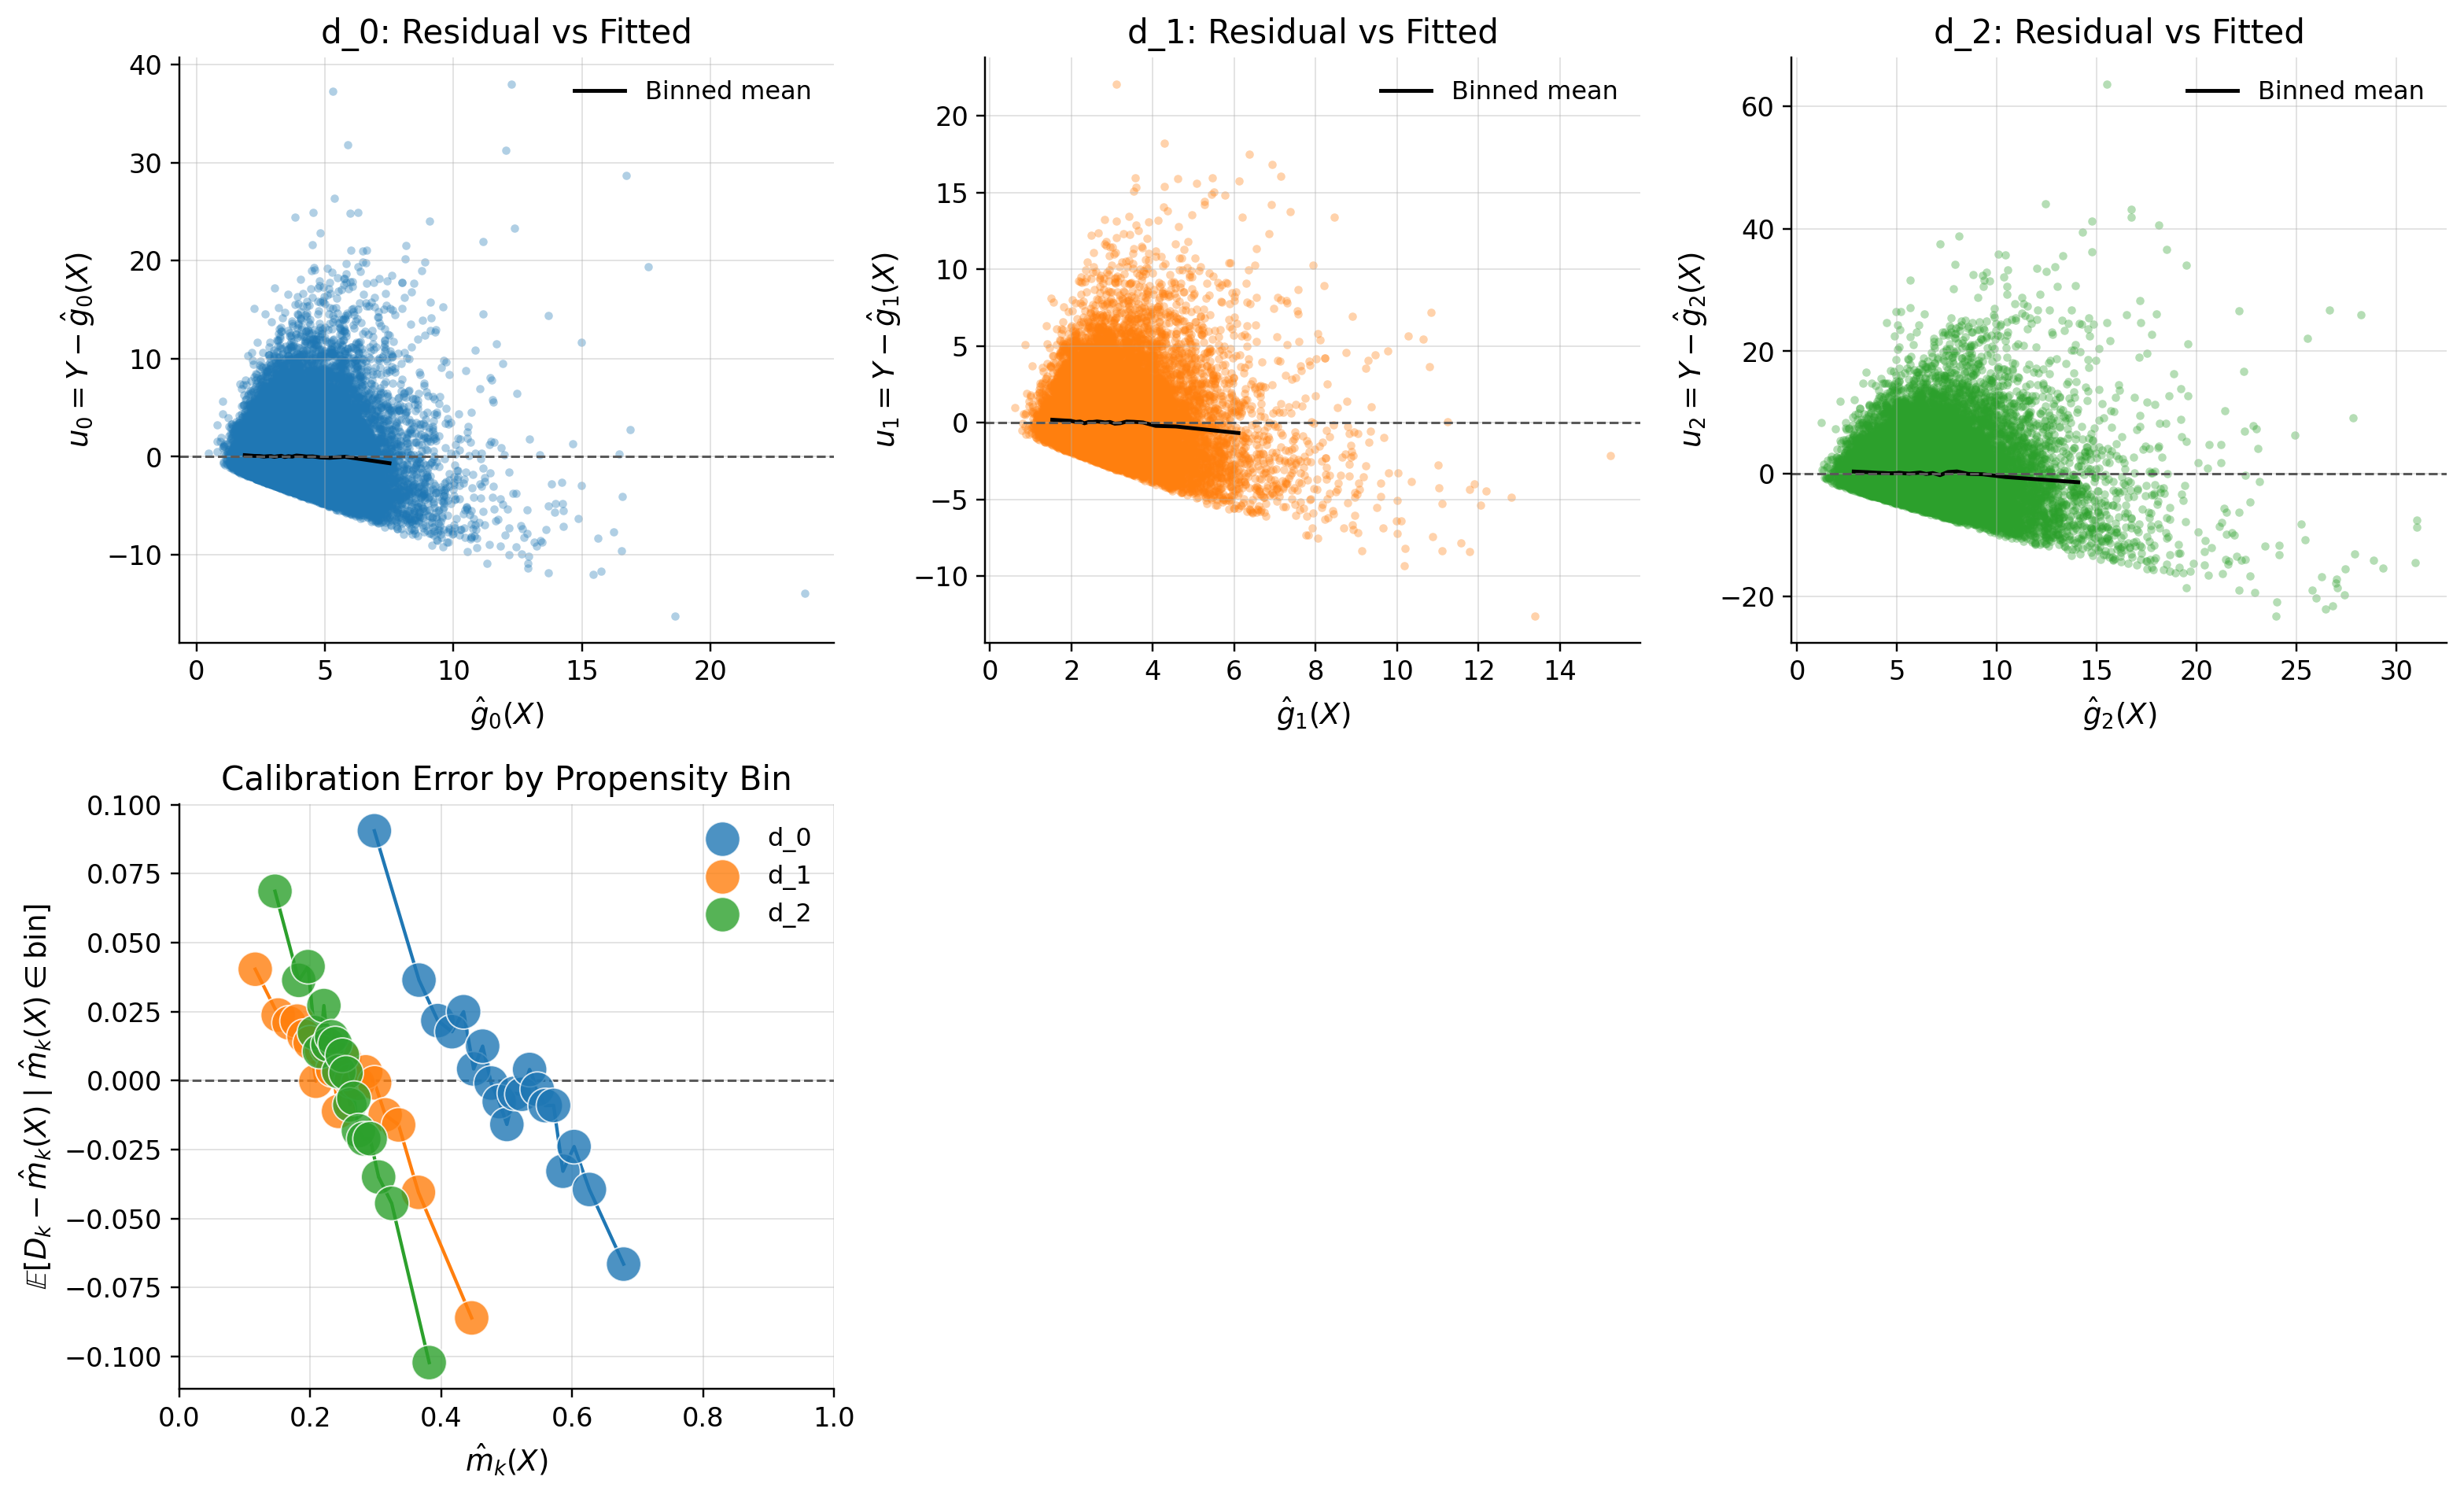

In [21]:
from causalis.scenarios.multi_unconfoundedness.refutation import plot_residual_diagnostics
plot_residual_diagnostics(dml_result)

# Conclusion

Set of mechanics labeled d_2 performed better and has effect 2.5355 (ci_abs: 2.4600, 2.6111) sessions per user. However, set of mechanics labeled d_1 perform worse than without mechanics -1.1772 (ci_abs: -1.2174, -1.1370) sessions. We need to turn them off